In [1]:
# ML Imports
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

def start_spark_session(mode='client'):
    if mode == 'cluster':
        spark = SparkSession.builder \
            .appName("cluster-test-2") \
            .master("spark://localhost:7077") \
            .config('deploy-mode', 'cluster') \
            .config('spark.executor.memory', '2g') \
            .getOrCreate()
    else:     
        conf = SparkConf().setAll([('spark.executor.memory', '16g'),('spark.driver.memory','16g')])
        sc = SparkContext(conf=conf)
        spark = SparkSession.builder \
            .appName("localApp") \
            .getOrCreate()
            
    return spark
  
spark = start_spark_session()   


25/01/22 19:21:02 WARN Utils: Your hostname, Maxims-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.102 instead (on interface en0)
25/01/22 19:21:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/22 19:21:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/22 19:21:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
from pyspark.sql import functions as F

basepath = "./data"

sp_tracks_genres = spark.read.format("csv").option("header", "true").load(
  f"{basepath}/sp_genres.csv")

sp_tracks_genres.printSchema()

# Filter out unpopular genres
genres_to_train = tuple(['rock', 'pop'])

pop_genres = ['pop', 'happy', 'dance', 'disco']
rock_genres = ['rock', 'metal', 'hardcore', 'alternative']

sp_rocks_genres = sp_tracks_genres.filter(
  " or ".join([f"track_genre like '%{g}%'" for g in rock_genres])).withColumn('track_genre', F.lit('rock'))

sp_pop_genres = sp_tracks_genres.filter(
  " or ".join([f"track_genre like '%{g}%'" for g in pop_genres])).withColumn('track_genre', F.lit('pop'))

sp_tracks_genres = sp_rocks_genres.union(sp_pop_genres)

sp_tracks_genres.printSchema()
print(sp_tracks_genres.count())


root
 |-- Unnamed: 0: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- track_genre: string (nullable = true)

root
 |-- Unnamed: 0: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- 

In [4]:
from pyspark.sql.types import *
from pyspark.sql import functions as F


label_column = "track_genre"
numerical_cols = ["energy", "tempo", "acousticness", "danceability", "liveness", "valence"]
                  
for column in numerical_cols:
    sp_tracks_genres = sp_tracks_genres.withColumn(column, F.col(column).cast(FloatType()))

tacks_model_data = sp_tracks_genres.select('track_id', 'track_genre', *numerical_cols)

# Review the feature distributions and schema
tacks_model_data.printSchema()
tacks_model_data.select(*numerical_cols).describe().show()

root
 |-- track_id: string (nullable = true)
 |-- track_genre: string (nullable = false)
 |-- energy: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- danceability: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)



25/01/22 19:21:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+
|summary|            energy|             tempo|      acousticness|       danceability|           liveness|            valence|
+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+
|  count|             28997|             28997|             28997|              28997|              28997|              28997|
|   mean|0.7204333030642077|124.76133466601458|0.2097648606088669| 0.5458733489925832|0.20694493438788245| 0.4990960238885881|
| stddev|0.2121907471272912|30.088355642190862|0.2701534315384835|0.16050628602940753|0.16576629517657007|0.24580823078939482|
|    min|            0.0167|            34.821|               0.0|             0.0513|            0.00986|             0.0166|
|    max|               1.0|           219.571|             0.996|              0.975|                1.0|     

In [5]:

# Feature Engineering stages for the pipeline
indexer = StringIndexer(inputCol='track_genre', outputCol='genre_id')
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features_assembled")
scaler = StandardScaler(inputCol="features_assembled", outputCol="features_scaled", withMean=True, withStd=True)

# Split the data into training and test sets
(train_data, test_data) = tacks_model_data.randomSplit([0.8, 0.2], seed=1234)
train_data.cache()
test_data.cache()

print(f"Кількість рядків у тренувальній вибірці: {train_data.count()}")
print(f"Кількість рядків у тестовій вибірці: {test_data.count()}")

# Multiclass evaluator to measure accuracy and F1
evaluator_ml = MulticlassClassificationEvaluator(labelCol="genre_id")
cv_evaluator = MulticlassClassificationEvaluator(labelCol="genre_id", metricName="accuracy")


Кількість рядків у тренувальній вибірці: 23290
Кількість рядків у тестовій вибірці: 5707


In [6]:
from pyspark.ml.classification import RandomForestClassifier


#Initial Random Forest Model with 50 trees and max depth of 5
rf = RandomForestClassifier(
    featuresCol="features_scaled", 
    labelCol="genre_id", 
    predictionCol="prediction",
    numTrees=50,  
    maxDepth=5, 
    seed=1234
)


# Create a pipeline with the stages: indexer, assembler, scaler, rf(our model)
rf_pipeline = Pipeline(stages=[indexer, assembler, scaler, rf])

# Train the model on the training data
rf_model = rf_pipeline.fit(train_data)

# Make predictions on the test data for evaluation
rf_predictions = rf_model.transform(test_data)

# Evaluate the model by computing the accuracy and F1 score
rf_accuracy = evaluator_ml.setMetricName("accuracy").evaluate(rf_predictions)
rf_f1 = evaluator_ml.setMetricName("f1").evaluate(rf_predictions)

print(f"Accuracy: {rf_accuracy}, f1: {rf_f1}")

Accuracy: 0.7292798317855266, f1: 0.7283670609960342


25/01/22 19:21:17 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Best accuracy: 0.7292798317855266


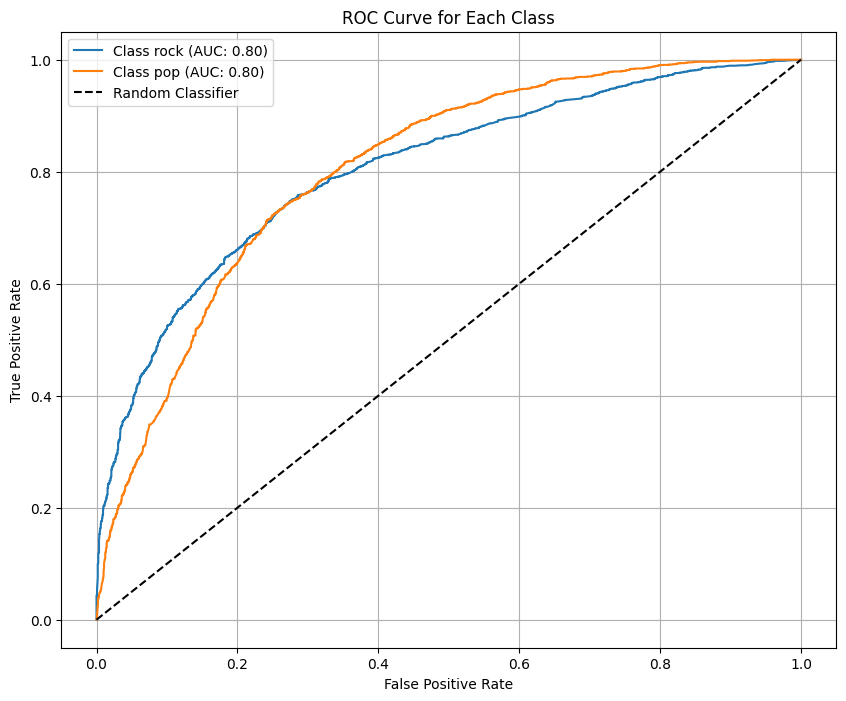

In [7]:
''' Cross Validation for hyperparameter tuning and K-fold validation ''' 
from src.utils import plot_roc

# Побудова сітки гіперпараметрів для Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5]) \
    .build()

# CrossValidator for Random Forest
cv_rf = CrossValidator(estimator=rf_pipeline,
            estimatorParamMaps=paramGrid_rf,
            evaluator=cv_evaluator, 
            numFolds=5,
            seed=1234, 
            parallelism=8)

# Fit the model on the training data with K-fold cross validation
cv_model_rf = cv_rf.fit(train_data).bestModel
cv_rf_predictions = cv_model_rf.transform(test_data)

rf_accuracy = evaluator_ml.setMetricName("accuracy").evaluate(cv_rf_predictions)
print(f"Best accuracy: {rf_accuracy}")

# Plot the ROC curve for the best model
plot_roc(rf_predictions, cv_model_rf.stages[0].labels)

# Save model for further use in "song_finder" notebook
cv_model_rf.write().overwrite().save("./models/spark_rf_model")